In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from pprint import pprint

In [2]:
df = pd.read_csv('C:/Users/saura/OneDrive/Desktop/Programming/assignment2/train.csv')

In [3]:
df.drop("PassengerId", axis=1, inplace=True)

In [4]:
last = df.pop('Survived')
df.insert(6, 'Survived', last)

In [5]:
df["Age"].fillna(df["Age"].median(skipna=True), inplace=True)

In [6]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,2.309677,29.404839,0.538710,0.382258,31.746982,0.393548
std,0.833993,12.810898,1.086018,0.792131,45.907139,0.488931
min,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.925000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.750000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,30.548950,1.000000
max,3.000000,71.000000,8.000000,5.000000,512.329200,1.000000


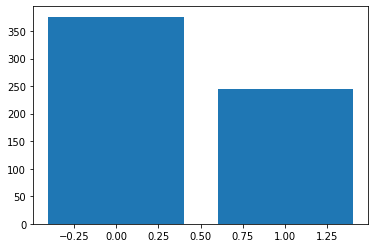

0    376
1    244
Name: Survived, dtype: int64

In [7]:
counts = df["Survived"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Survived'].value_counts()

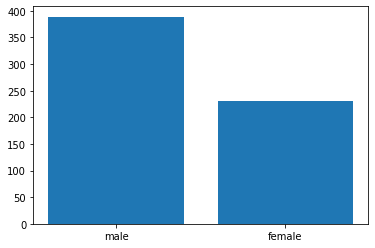

male      389
female    231
Name: Sex, dtype: int64

In [8]:
counts = df["Sex"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Sex'].value_counts()

,Sex,Survived
0,female,0.748918
1,male,0.182519


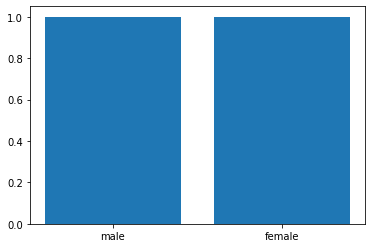

In [9]:
plt.bar(x='Sex',height='Survived',data=df)
df.groupby('Sex',as_index=False).Survived.mean()

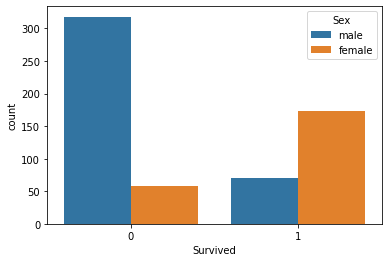

In [10]:
sns.countplot(x='Survived', hue='Sex', data=df)

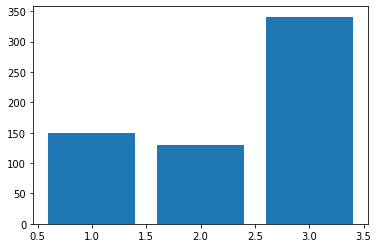

3    341
1    149
2    130
Name: Pclass, dtype: int64

In [11]:
counts = df["Pclass"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Pclass'].value_counts()

,Pclass,Survived
0,1,0.597315
1,2,0.515385
2,3,0.258065


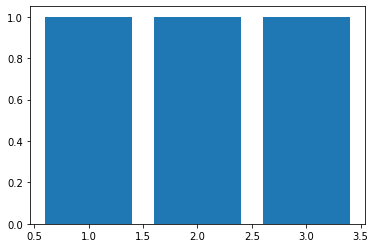

In [12]:
plt.bar(x='Pclass',height='Survived',data=df)
df.groupby('Pclass',as_index=False).Survived.mean()

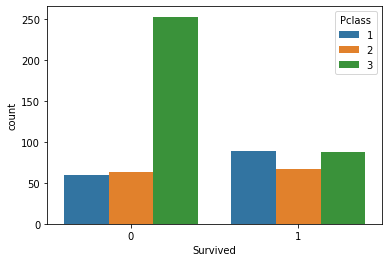

In [13]:
sns.countplot(x='Survived', hue='Pclass', data=df)

28.0

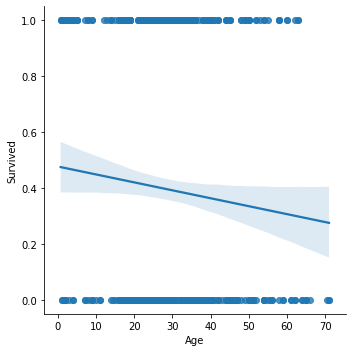

In [14]:
sns.lmplot(x='Age',y='Survived',data=df)
df.Age.median()

In [15]:
def train_test_split(df, test_size):

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [16]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=150)

In [17]:
data = train_df.values

In [18]:
def purity(data):
    
    survived_column = data[:, -1]
    unique_classes = np.unique(survived_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [19]:
def classify_data(data):
    
    survived_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(survived_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [20]:
def get_potential_splits(data):
    
    splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        splits[column_index] = unique_values
    
    return splits

In [21]:

def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [22]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [23]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [24]:

def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [25]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [26]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

         
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [27]:
my_tree = decision_tree_algorithm(train_df, max_depth=7)
pprint(my_tree)

{'Sex = male': [{'Age <= 12.0': [{'Pclass = 3': [{'Fare <= 20.525': [1,
                                                                     {'Parch = 2': [{'Fare <= 31.3875': [{'Age <= 3.0': [1,
                                                                                                                         0]},
                                                                                                         0]},
                                                                                    0]}]},
                                                 1]},
                                 {'Fare <= 9.225': [{'Age <= 32.0': [{'Age <= 30.0': [0,
                                                                                      {'Fare <= 7.8542': [1,
                                                                                                          0]}]},
                                                                     0]},
                                      

In [28]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [29]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["Survived"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [30]:
accuracy = calculate_accuracy(test_df, my_tree)
accuracy

0.7733333333333333

## train.csv

In [31]:
df_test = pd.read_csv('C:/Users/saura/OneDrive/Desktop/Programming/assignment2/test.csv')

In [32]:
df_test.drop("PassengerId", axis=1, inplace=True)

In [33]:
l = df_test.pop('Survived')
df_test.insert(6, 'Survived', l)

In [34]:
df_test.isnull().sum()

Pclass       0
Sex          0
Age         46
SibSp        0
Parch        0
Fare         0
Survived     0
dtype: int64

In [35]:
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)

In [36]:
df_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Survived    0
dtype: int64

In [37]:
data_test = df_test.values

In [38]:
accuracy = calculate_accuracy(df_test, my_tree)
accuracy

0.8044280442804428